<p style="text-align: center;">
    МИНОБРНАУКИ РОССИИ <br>
    РГУ НЕФТИ И ГАЗА (НИУ) ИМЕНИ И.М. ГУБКИНА<br>
    ФАКУЛЬТЕТ АВТОМАТИКИ И ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ<br>
    КАФЕДРА АВТОМАТИЗИРОВАННЫХ СИСТЕМ УПРАВЛЕНИЯ<br>
    ДИСЦИПЛИНА <br>
        «Модели и методы обработки статистической информации в автоматизированном управлении НГО»
    <br><br> <br> <br> <br> <br> <br><br>
    ОТЧЁТ <br>
    по лабораторной работе №2 <br>
    «Статистический анализ одномерных выборок. Проверка статистических гипотез.»<br> <br> <br> <br> <br><br> <br> <br> <br> <br> <br><br>
</p>

<p style="text-align: right;">
    Выполнил: студент группы АС-21-05, Негробов В.А.<br>
    Проверила: старший преподаватель, Степанкина О.А.<br><br> <br> <br> <br> <br><br> <br> <br> <br> <br> <br><br><br> <br> <br> <br> <br><br>
</p>

<p style="text-align: center;">
    МОСКВА 2024
</p>

----------------------------------------------------------------------------------------
<br><br>Вариант 14 (2)

Дано:
7 одномерных случайных величин (одномерных выборок)
Задание:
1. Проверить каждую выборку на принадлежность к некоторому закону
распределения (данные и набор гипотез из работы 1), используя критерии хиквадрат и Колмогорова-Смирнова.

2. Можно ли в качестве оценки математического ожидания использовать
округленное до целого среднее значение? Обосновать.

3. Для пар нормально распределенных случайных величин проверить: $\mu_1 = \mu_2$; $\sigma_1^2 = \sigma_2^2$

4. Проверить однородность тех же (п. 3) выборок, используя непараметрические
критерии Колмогорова-Смирнова, Мана-Уитни, Уилкоксона.

5. Используя методы понижения дисперсии, оценить основные характеристики
выборки.

6. Провести проверку на наличие тренда в выборках. 

# Предварительная подготовка

Подключение используемых библиотек:

In [522]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pymannkendall as mk
from outliers import smirnov_grubbs as grubbs
from collections import namedtuple

Подключим стиль ggplot вывода графиков:

In [523]:
plt.style.use('ggplot')

Создадим функцию, выполняющую проверку на нормальность с помощью критерия Хи-квадрт:

In [524]:
def get_uniform_freqs(values, mean=10):
    
    length = len(values)
    m = length // mean
    freqs = np.zeros(m)
    

    for i, (lower_bound, upper_bound) in enumerate(zip(x_values[:-1], x_values[1:])):
        freqs[i] = ((values > lower_bound) & (values < upper_bound)).sum()
    return freqs, mean

In [525]:
def get_freqs(values, inv_func, mean=10):
    
    assert inv_func is not None

    length = len(values)
    m = length // mean
    mean = length / m
    freqs = np.empty(m)
    x_values = np.array([inv_func(p) for p in np.linspace(0, 1, m+1)])
    
    freqs[0] = ((values >= x_values[0]) & (values <= x_values[1])).sum()
    for i, (lower_bound, upper_bound) in enumerate(zip(x_values[1:-1], x_values[2:])):
            freqs[i + 1] = ((values > lower_bound) & (values <= upper_bound)).sum()
            
    return freqs, mean

In [526]:
def chisquaretest(values, distribution='uniform', mean=10):
    
    func = None
    
    if distribution == 'norm':
        func = stats.norm.ppf
    if distribution == 'uniform':
        func = lambda p: p
    freqs, mean = get_freqs(values, func, mean)
    expected_freqs = np.ones_like(freqs) * mean
    return stats.chisquare(freqs, expected_freqs)

Создадим функцию, выполняющую проверку на равенство дисперсий с использованием статистики Фишера-Снедекора:

In [527]:
FischerSnedekorTestResult = namedtuple(
    'FischerSnedekorTestResult', ['statistic', 'pvalue']
)

In [528]:
def fischersnedekortest(value1, value2):
    statistic = (np.std(value1, ddof=1) / np.std(value2,ddof=1))**2
    pvalue = stats.f.sf(statistic, len(value1) - 1, len(value2) - 1)
    return FischerSnedekorTestResult(statistic, pvalue)

Считаем данные:

In [529]:
names = [f'var{i + 1}' for i in range(7)]
df = pd.read_excel('data1.xlsx', sheet_name='2',
                   header=None, names=names)
df

,var1,var2,var3,var4,var5,var6,var7
0,-16.427992,10.337568,10.094972,12.235925,10,16,-2.336080
1,-29.368694,20.601542,15.573639,12.159321,6,15,5.041232
2,-6.561724,1.876631,2.625150,24.552468,10,14,6.987623
3,7.358867,17.243398,15.855155,12.348476,9,14,9.542421
4,6.692038,-23.179041,11.742064,19.597243,9,15,11.116361
...,...,...,...,...,...,...,...
495,-14.625446,28.472332,3.514818,14.900529,8,9,11.921887
496,-8.260384,29.031223,15.098677,11.791395,9,12,12.517533
497,-26.231086,-10.672482,2.563150,13.363092,10,11,12.910253
498,2.804773,-34.769869,20.353306,2.508352,7,13,13.257425


# Задание 1. Проверить каждую выборку на принадлежность к некоторому закону распределения (данные и набор гипотез из работы 1), используя критерии хиквадрат и Колмогорова-Смирнова.

Критерий хи-квадрат Пирсона: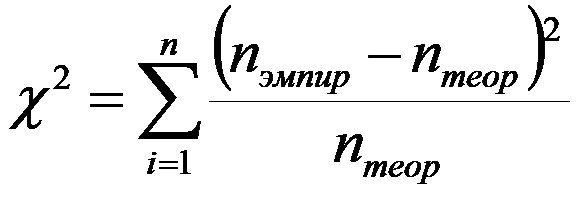

Критерий Колмогорова-Смиронова: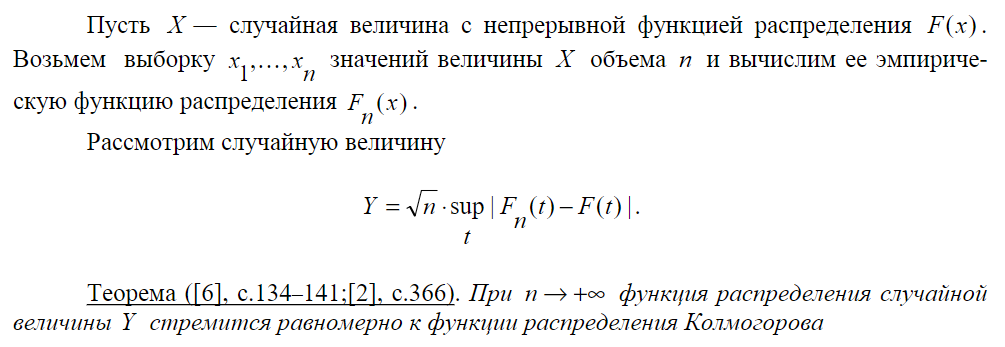

## Предварительное заключение о законе распределения каждой случайной величины.

Случайные величины 2, 3, 4, 7 имеют нормальное распределение, поскольку эксцесс ≈ 0, коэффициент асимметрии ≈ 0, графически имеют вид нормального распределения.

Случайная величина 1 имеет равномерное распределение, поскольку эксцесс ≈ -1.2, коэффициент асимметрии ≈ 0, графически имеют вид равномерного распределения.

Случайная величина 5 имеет дискретное распределение, поскольку эксцесс ≈ 0, коэффициент асимметрии ≈ 0, графически имеют вид равномерного распределения, значения СВ - ограниченный набор дискретных значений.

Случайная величина 6 имеет распределение Пуассона, поскольку эксцесс ≈ 0, коэффициент асимметрии ≈ 0, графически имеют вид равномерного распределения, значения СВ - ограниченный набор дискретных значений, математическое ожидание ≈ дисперсии. 


| Номер выборки|Название|Параметры|
|--------------|:-----:||
|1|равномерное распределение|$a = -33.9$, $b = 11.9$|
|2|нормальное распределение|$\mu = 8.8$, $\sigma = 18.3$|
|3|нормальное распределение|$\mu = 8.8$, $\sigma = 13.4$|
|4|нормальное распределение|$\mu = 12.6$, $\sigma = 7.0$|
|5|биномиальное распределение|$p = 0.84$, $n = 10$|
|6|распределение Пуассона|$k = 21$, $\lambda = 12$|
|7|нормальное распределение|$\mu = 7.9$, $\sigma = 3.8$|

Нормально распределённые величины:

In [530]:
nd_vars = ['var2', 'var3', 'var4', 'var7']

In [531]:
table_first = {'variable': [],
               'Kolmogorov-Smirnov pvalue': [], 'ks accepted': [],
               'chi2 pvalue':[], 'chi2 accepted': []}

In [532]:
val = df['var1']
val = (val - val.min()) / (val.max() - val.min())
res_ks = stats.kstest(val, 'uniform')
res_chi2 = chisquaretest(val, 'uniform')

table_first['variable'].append('var1')
table_first['Kolmogorov-Smirnov pvalue'].append(res_ks.pvalue)
table_first['ks accepted'].append((res_ks.pvalue > 0.05))
table_first['chi2 pvalue'].append(res_chi2.pvalue)
table_first['chi2 accepted'].append((res_chi2.pvalue > 0.05))

print(res_ks)
print(res_chi2)

KstestResult(statistic=0.04431901840490793, pvalue=0.27169482660840694)
Power_divergenceResult(statistic=54.800000000000004, pvalue=0.2640145407051378)


In [533]:
freqs, mean = get_freqs(df['var5'], lambda p: stats.binom.ppf(p, 12, 0.84), mean=160)

expected_freqs = np.ones_like(freqs) * mean
res_chi2 = stats.chisquare(freqs, expected_freqs)

table_first['variable'].append('var5')
table_first['Kolmogorov-Smirnov pvalue'].append(np.nan)
table_first['ks accepted'].append(np.nan)
table_first['chi2 pvalue'].append(res_chi2.pvalue)
table_first['chi2 accepted'].append((res_chi2.pvalue > 0.05))
res_chi2

Power_divergenceResult(statistic=736.6240000000001, pvalue=1.1069570772622386e-160)

In [534]:
freqs, mean = get_freqs(df['var6'], lambda p: stats.poisson.ppf(p, 12), mean=160)
expected_freqs = np.ones_like(freqs) * mean
res_chi2 = stats.chisquare(freqs, expected_freqs)
table_first['variable'].append('var6')
table_first['Kolmogorov-Smirnov pvalue'].append(np.nan)
table_first['ks accepted'].append(np.nan)
table_first['chi2 pvalue'].append(res_chi2.pvalue)
table_first['chi2 accepted'].append((res_chi2.pvalue > 0.05))
res_chi2

Power_divergenceResult(statistic=0.9159999999999999, pvalue=0.6325474762073633)

In [535]:
for col in nd_vars:
    mu = df[col].mean()
    sigma = df[col].std()
    res_ks = stats.kstest((df[col] - mu) / sigma, 'norm')
    res_chi2 = chisquaretest((df[col] - mu) / sigma, 'norm')
    
    table_first['variable'].append(col)
    table_first['Kolmogorov-Smirnov pvalue'].append(res_ks.pvalue)
    table_first['ks accepted'].append((res_ks.pvalue > 0.05))
    table_first['chi2 pvalue'].append(res_chi2.pvalue)
    table_first['chi2 accepted'].append((res_chi2.pvalue > 0.05))

    print(col)
    print(res_ks)
    print(res_chi2)
    print()

var2
KstestResult(statistic=0.023701748414318713, pvalue=0.9350861476037631)
Power_divergenceResult(statistic=30.599999999999998, pvalue=0.9817477257369395)

var3
KstestResult(statistic=0.035148746888719606, pvalue=0.5551205895441661)
Power_divergenceResult(statistic=54.2, pvalue=0.28277962689765224)

var4
KstestResult(statistic=0.021568490889172037, pvalue=0.9702822186071135)
Power_divergenceResult(statistic=46.800000000000004, pvalue=0.5627663523661661)

var7
KstestResult(statistic=0.02864931656570535, pvalue=0.7952828701879684)
Power_divergenceResult(statistic=55.800000000000004, pvalue=0.2344896822856472)



In [536]:
first_table = pd.DataFrame(table_first)
first_table = first_table.set_index('variable')
first_table

,Kolmogorov-Smirnov pvalue,ks accepted,chi2 pvalue,chi2 accepted
variable,,,,
var1,0.271695,True,2.640145e-01,True
var5,NaN,NaN,1.106957e-160,False
var6,NaN,NaN,6.325475e-01,True
var2,0.935086,True,9.817477e-01,True
var3,0.555121,True,2.827796e-01,True
var4,0.970282,True,5.627664e-01,True
var7,0.795283,True,2.344897e-01,True


# Задание 2. Можно ли в качестве оценки математического ожидания использовать округленное до целого среднее значение? Обосновать. 

Критерий Стьюдента: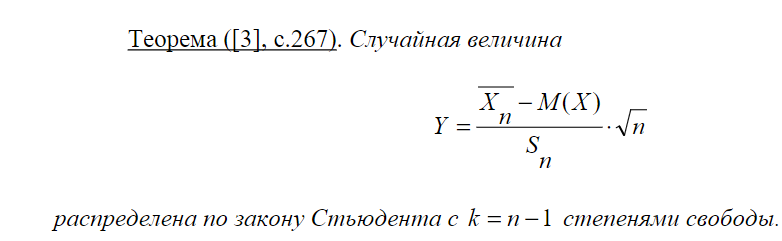

In [537]:
table_second = {'variable': [], 'T-test pvalue': [], 'ttest accepted': []}
for col in df.columns:
    mu = df[col].mean()
    res_ttest = stats.ttest_1samp(df[col], round(mu))
    table_second['variable'].append(col)
    table_second['T-test pvalue'].append(res_ttest.pvalue)
    table_second['ttest accepted'].append((res_ttest.pvalue > 0.05))
    print(res_ttest)
    print()

Ttest_1sampResult(statistic=-0.586331412710869, pvalue=0.5579179523756326)

Ttest_1sampResult(statistic=-0.2272187909792269, pvalue=0.8203466764544802)

Ttest_1sampResult(statistic=-0.3077253665126743, pvalue=0.758419713349292)

Ttest_1sampResult(statistic=-1.1954064443797716, pvalue=0.23249605556564346)

Ttest_1sampResult(statistic=5.386942239753458, pvalue=1.1062190251107552e-07)

Ttest_1sampResult(statistic=0.7567212713514987, pvalue=0.4495739942503243)

Ttest_1sampResult(statistic=-0.4578596858835891, pvalue=0.6472525551407535)



In [538]:
second_table = pd.DataFrame(table_second)
second_table = second_table.set_index('variable')
second_table

,T-test pvalue,ttest accepted
variable,,
var1,5.579180e-01,True
var2,8.203467e-01,True
var3,7.584197e-01,True
var4,2.324961e-01,True
var5,1.106219e-07,False
var6,4.495740e-01,True
var7,6.472526e-01,True


# Задание 3. Для пар нормально распределенных случайных величин проверить: $ \mu_1=\mu_2$; $\sigma_1^2 = \sigma_2^2$

Критерий стьюдента: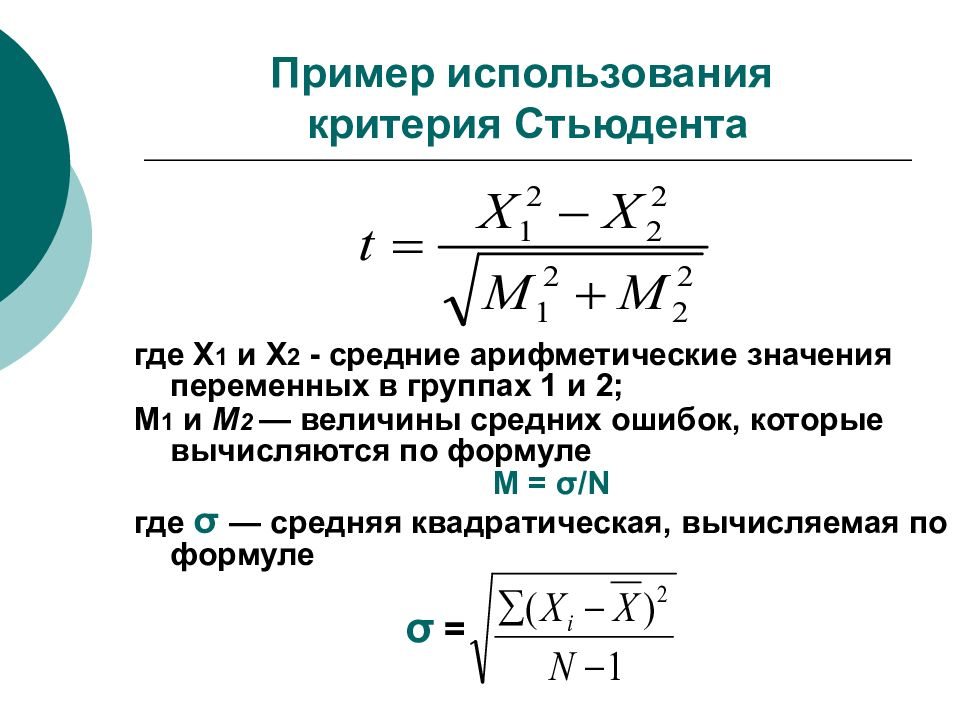
Критерий Фишера-Снедекора: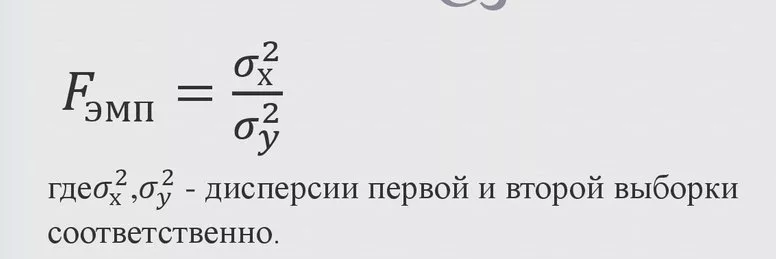

In [539]:
table_third = {'pairs of variables': [], 'T-test pvalue': [], 'ttest accepted': [], 'Fisher-Snedekor pvalue': [], 'fisher accepted': []}

for i in range(len(nd_vars)):
    for j in range(i + 1, len(nd_vars)):
        res_ttest = stats.ttest_ind(df[nd_vars[i]], df[nd_vars[j]])
        res_fisher = fischersnedekortest(df[nd_vars[i]], df[nd_vars[j]])
        table_third['pairs of variables'].append(f'{nd_vars[i]}, {nd_vars[j]}')
        table_third['T-test pvalue'].append(res_ttest.pvalue)
        table_third['ttest accepted'].append((res_ttest.pvalue > 0.05))
        table_third['Fisher-Snedekor pvalue'].append(res_fisher.pvalue)
        table_third['fisher accepted'].append((res_ttest.pvalue > 0.05))
        print(f'{nd_vars[i]}, {nd_vars[j]}: {res_ttest}')
        print(f'{nd_vars[i]}, {nd_vars[j]}: {res_fisher}')
        print()

var2, var3: Ttest_indResult(statistic=-0.0016522260814812353, pvalue=0.9986820451093386)
var2, var3: FischerSnedekorTestResult(statistic=1.867668674654247, pvalue=2.2851906823540148e-12)

var2, var4: Ttest_indResult(statistic=-4.346003637549657, pvalue=1.528315048659413e-05)
var2, var4: FischerSnedekorTestResult(statistic=6.8715557321840635, pvalue=2.010217388584183e-90)

var2, var7: Ttest_indResult(statistic=1.065567488447388, pvalue=0.286876921958357)
var2, var7: FischerSnedekorTestResult(statistic=22.855375849467364, pvalue=1.4306207954633132e-200)

var3, var4: Ttest_indResult(statistic=-5.634334826908801, pvalue=2.2852824997702254e-08)
var3, var4: FischerSnedekorTestResult(statistic=3.6792156046929265, pvalue=2.789925932632591e-45)

var3, var7: Ttest_indResult(statistic=1.4331413159971242, pvalue=0.15213063712391295)
var3, var7: FischerSnedekorTestResult(statistic=12.237382443488526, pvalue=1.3659805960196724e-140)

var4, var7: Ttest_indResult(statistic=13.193747847724126, pvalue=9

In [540]:
third_table = pd.DataFrame(table_third)
third_table = third_table.set_index('pairs of variables')
third_table

,T-test pvalue,ttest accepted,Fisher-Snedekor pvalue,fisher accepted
pairs of variables,,,,
"var2, var3",9.986820e-01,True,2.285191e-12,True
"var2, var4",1.528315e-05,False,2.010217e-90,False
"var2, var7",2.868769e-01,True,1.430621e-200,True
"var3, var4",2.285282e-08,False,2.789926e-45,False
"var3, var7",1.521306e-01,True,1.365981e-140,True
"var4, var7",9.360902e-37,False,3.498809e-39,False


# Задание 4. Проверить однородность тех же (п. 3) выборок, используя непараметрические критерии Колмогорова-Смирнова, Мана-Уитни, Уилкоксона.

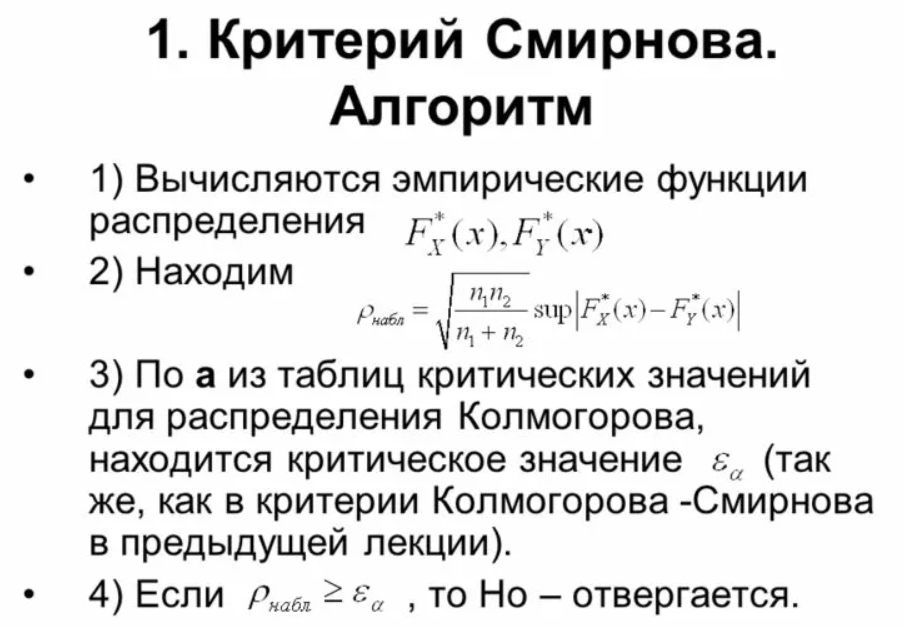
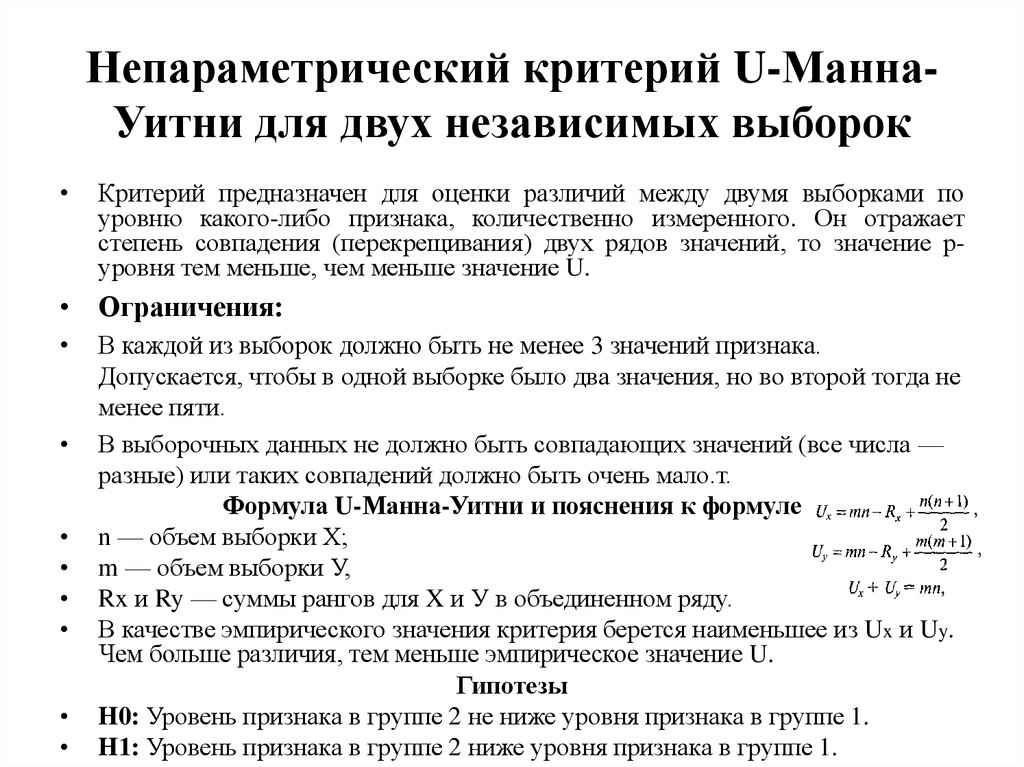
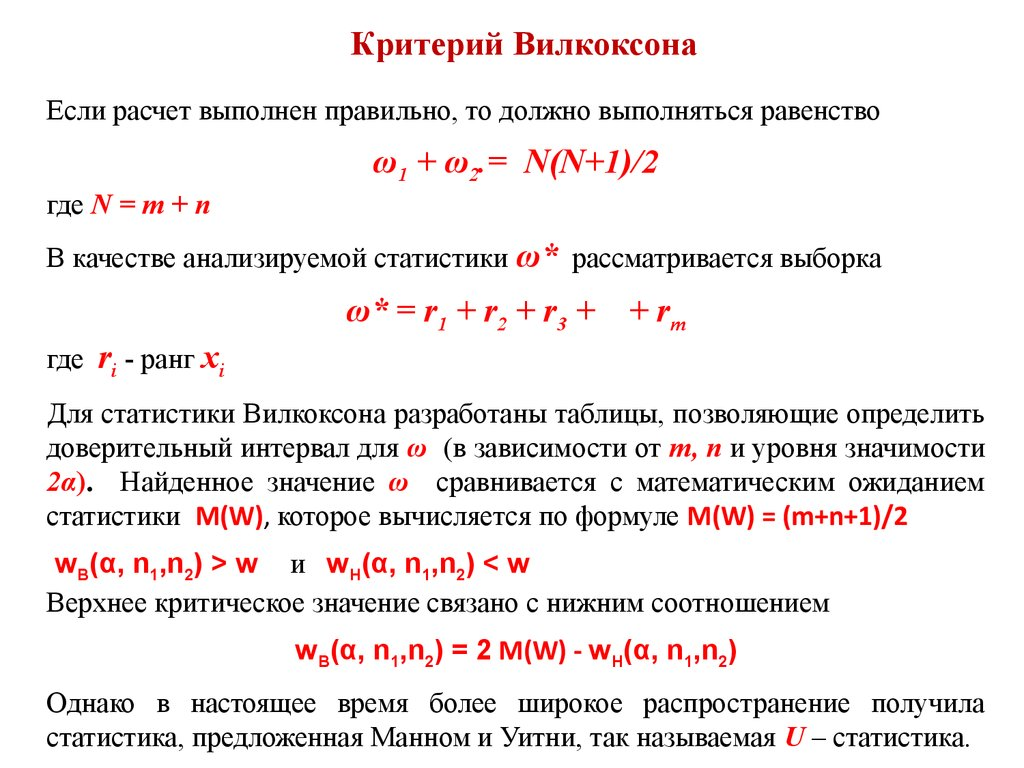

In [541]:
table_fourth = {'pairs of variables': [], 'Kolmogorov-Smirnov pvalue': [], 'ks accepted': [], 'Mann-Whitney pvalue': [], 'mw accepted': [], 'Wilcoxon pvalue': [], 'w accepted': []}

for i in range(len(nd_vars)):
    for j in range(i + 1, len(nd_vars)):
        res_ks = stats.ks_2samp(df[nd_vars[i]], df[nd_vars[j]])
        res_mw = stats.mannwhitneyu(df[nd_vars[i]], df[nd_vars[j]])
        res_w = stats.wilcoxon(df[nd_vars[i]], df[nd_vars[j]])
        table_fourth['pairs of variables'].append(f'{nd_vars[i]}, {nd_vars[j]}')

        table_fourth['Kolmogorov-Smirnov pvalue'].append(res_ks.pvalue)
        table_fourth['ks accepted'].append((res_ks.pvalue > 0.05))

        table_fourth['Mann-Whitney pvalue'].append(res_mw.pvalue)
        table_fourth['mw accepted'].append((res_mw.pvalue > 0.05))

        table_fourth['Wilcoxon pvalue'].append(res_w.pvalue)
        table_fourth['w accepted'].append((res_w.pvalue > 0.05))

        print(f'{nd_vars[i]}, {nd_vars[j]}: {res_ks}')
        print(f'{nd_vars[i]}, {nd_vars[j]}: {res_mw}')
        print(f'{nd_vars[i]}, {nd_vars[j]}: {res_w}')
        print()

var2, var3: KstestResult(statistic=0.08, pvalue=0.08150167321107067)
var2, var3: MannwhitneyuResult(statistic=124874.0, pvalue=0.9780753479760319)
var2, var3: WilcoxonResult(statistic=62602.0, pvalue=0.9943226071084724)

var2, var4: KstestResult(statistic=0.306, pvalue=4.568071862286397e-21)
var2, var4: MannwhitneyuResult(statistic=104757.0, pvalue=9.306296100748736e-06)
var2, var4: WilcoxonResult(statistic=49432.0, pvalue=4.473063663556086e-05)

var2, var7: KstestResult(statistic=0.332, pvalue=8.535314188970944e-25)
var2, var7: MannwhitneyuResult(statistic=129753.0, pvalue=0.29801462228433884)
var2, var7: WilcoxonResult(statistic=58745.0, pvalue=0.2299942693611401)

var3, var4: KstestResult(statistic=0.266, pvalue=5.833972860643141e-16)
var3, var4: MannwhitneyuResult(statistic=102026.0, pvalue=4.886233820338595e-07)
var3, var4: WilcoxonResult(statistic=45014.0, pvalue=5.082585030747818e-08)

var3, var7: KstestResult(statistic=0.324, pvalue=1.2979749441222893e-23)
var3, var7: Mannwhitn

In [542]:
fourth_table = pd.DataFrame(table_fourth)
fourth_table = fourth_table.set_index('pairs of variables')
fourth_table

,Kolmogorov-Smirnov pvalue,ks accepted,Mann-Whitney pvalue,mw accepted,Wilcoxon pvalue,w accepted
pairs of variables,,,,,,
"var2, var3",8.150167e-02,True,9.780753e-01,True,9.943226e-01,True
"var2, var4",4.568072e-21,False,9.306296e-06,False,4.473064e-05,False
"var2, var7",8.535314e-25,False,2.980146e-01,True,2.299943e-01,True
"var3, var4",5.833973e-16,False,4.886234e-07,False,5.082585e-08,False
"var3, var7",1.297975e-23,False,1.053947e-01,True,1.361565e-01,True
"var4, var7",1.309317e-37,False,4.379789e-33,False,5.744238e-31,False


# Задание 5. Используя методы понижения дисперсии, оценить основные характеристики выборки.

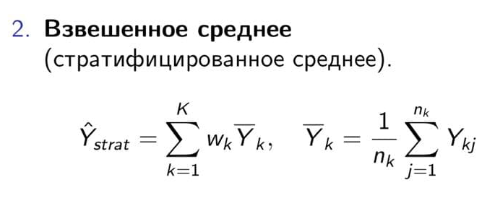

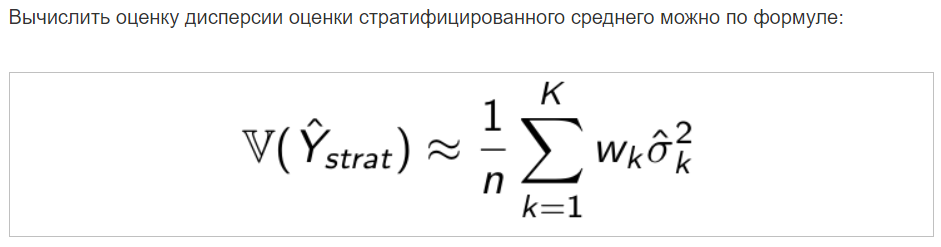

Используем метод стратификации, выбирающий случайные значения выборки:

In [546]:
length = len(df)
table_fifth = {'variable': [], 'mean': [], 'mean_var': [], 'var': []}

for col in df.columns:
    best_mean_var = np.inf
    best_mean = None
    best_var = None
    for i in range(10_000):
        for v in range(1, 6):
            p = v / 10
            N = 500 * p
            positions = np.random.choice([0, 1, 2], length, p=[p, p, 1 - 2*p])
            values1 = df[col].values[positions==0]
            values2 = df[col].values[positions==1]
            mean = (values1.mean() + values2.mean()) / 2
            mean_var = (values1.var() / N + values2.var() / N) / 2
            var = (values1.var() + values2.var()) / 2
            if mean_var < best_mean_var:
                best_mean_var = mean_var
                best_mean = mean
                best_var = var
    table_fifth['variable'].append(col)
    table_fifth['mean'].append(best_mean)
    table_fifth['mean_var'].append(best_mean_var)
    table_fifth['var'].append(var)
    

fourth_table = pd.DataFrame(table_fifth)
fourth_table = fourth_table.set_index('variable')
fourth_table

,mean,mean_var,var
variable,,,
var1,-10.346922,0.714912,183.918643
var2,9.007425,1.290545,337.159044
var3,8.623419,0.692898,178.642873
var4,12.539484,0.188823,48.826986
var5,8.409161,0.010267,2.643838
var6,12.072849,0.043805,11.317232
var7,7.960261,0.056327,14.651953


# Задание 6. Провести проверку на наличие тренда в выборках.

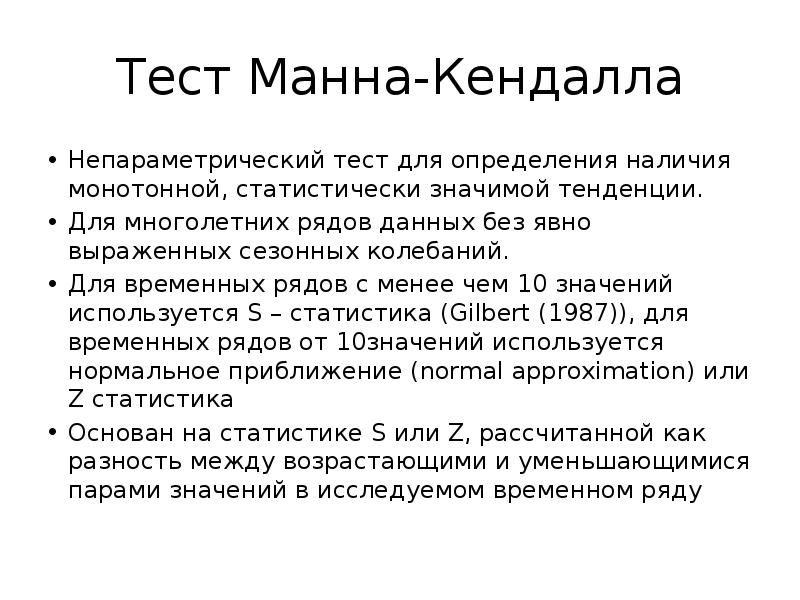

Визуализация СВ, предположительно имеющей тренд:

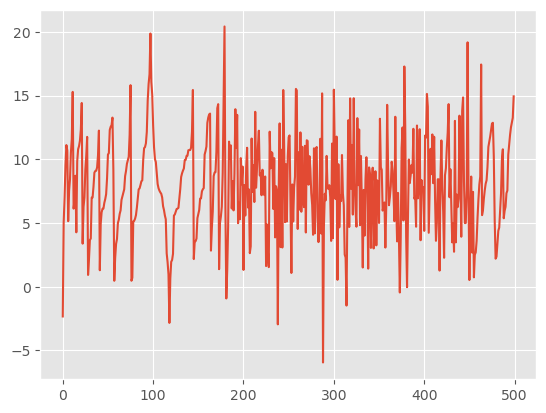

In [544]:
plt.plot(df['var7']);

In [545]:
for col in df.columns:
    print(mk.original_test(df[col]))
    print()

Mann_Kendall_Test(trend='no trend', h=False, p=0.7848389533039548, z=-0.27301855382509066, Tau=-0.008176352705410821, s=-1020.0, var_s=13930414.666666666, slope=-0.0011077352307304112, intercept=-9.310643589703567)

Mann_Kendall_Test(trend='no trend', h=False, p=0.8332061585460118, z=-0.21059135525890665, Tau=-0.006308617234468938, s=-787.0, var_s=13930413.666666666, slope=-0.0012949468077039787, intercept=9.033113327453314)

Mann_Kendall_Test(trend='no trend', h=False, p=0.7877237916826942, z=0.2692675628991326, Tau=0.008064128256513026, s=1006.0, var_s=13930414.666666666, slope=0.0011830854821161042, intercept=8.65201013750467)

Mann_Kendall_Test(trend='no trend', h=False, p=0.07727564889714578, z=-1.766716916362906, Tau=-0.05286573146292585, s=-6595.0, var_s=13930411.666666666, slope=-0.0039000049410246843, intercept=13.729562104510117)

Mann_Kendall_Test(trend='no trend', h=False, p=0.6121120103048834, z=-0.5070610115092383, Tau=-0.014933867735470941, s=-1863.0, var_s=13484626.3333

Ни в одной последовательности случайных величин нет тренда.